In [1]:
# Standard code libraries
import numpy as np
from scipy.signal import find_peaks

import matplotlib.pyplot as plt

# Custom code libraries from the ReSurfEMG
import resurfemg.preprocessing.envelope as evl
from resurfemg.postprocessing.baseline import moving_baseline
from resurfemg.postprocessing.event_detection import find_occluded_breaths
from resurfemg.postprocessing.event_detection import onoffpeak_baseline_crossing
import resurfemg.postprocessing.quality_assessment as qa

%matplotlib widget

In [3]:
# Define valid dummy signal
fs_vent = 100
s_vent = np.array([(s_t) for s_t in range(10*fs_vent)])
t_vent = (s_vent + 1)/fs_vent
rr = 12
t_r = 60/rr
f_r = 1/t_r
y_sin = np.sin((f_r* t_vent)* 2 * np.pi)
y_sin[y_sin > 0] = 0
y_t = 5 * y_sin

peaks_source = find_occluded_breaths(
    p_aw=y_t,
    peep=0,
    fs=fs_vent,
)

peak_ends = s_vent[(t_vent%t_r == 0)]
peak_starts = s_vent[((t_vent+t_r/2)%t_r == 0)]

PTP_occs = np.zeros(peaks_source.shape)
for idx in range(len(peaks_source)):
    PTP_occs[idx] = np.trapz(
        -y_t[peak_starts[idx]:peak_ends[idx]],
        dx=1/fs_vent
    )

valid_poccs, criteria_matrix = qa.pocc_quality(
    y_t, peaks_source, peak_ends, PTP_occs)
valid_poccs, criteria_matrix

(array([ True,  True]),
 array([[0.01006272, 0.01006272],
        [0.06188801, 0.06188801],
        [0.02193931, 0.02193931]]))

In [5]:
# Simulate negative deflection in upslope
y_sin_shifted = np.sin(((f_r-0.025)* t_vent - 0.11)* 2 * np.pi)
y_sin_shifted[y_sin_shifted > 0] = 0
y_sin_shifted[t_vent < 7.0] = 0
y_t_shifted = 5 * y_sin + 4 * y_sin_shifted

negative_upslope_poccs, criteria_matrix = qa.pocc_quality(
    y_t_shifted, peaks_source, peak_ends, PTP_occs)
negative_upslope_poccs, criteria_matrix

(array([ True, False]),
 array([[ 0.01006272, -0.00181876],
        [ 0.06188801,  0.0308622 ],
        [ 0.02193931,  0.01094065]]))

In [6]:
# Simulate steep upslope
y_sin = np.sin((f_r* t_vent)* 2 * np.pi)
y_sin[y_sin > 0] = 0
y_sin_shifted = np.sin((f_r* t_vent - 0.4)* 2 * np.pi) 
y_sin_shifted[y_sin_shifted > 0] = 0
y_sin_shifted = y_sin_shifted ** 4
y_t_steeper = 1000 * y_sin * y_sin_shifted

peaks_steeper, _ = find_peaks(-y_t_steeper, prominence=0.1)
y_baseline = moving_baseline(-y_t_steeper, 7.5*fs_vent, fs_vent//5)

_, peak_starts_steep, peak_ends_steep, _, _, _ = onoffpeak_baseline_crossing(
    y_t_steeper, y_baseline, peaks_steeper)

PTP_occs_steep = np.zeros(peaks_steeper.shape)
for idx in range(len(peaks_steeper)):
    PTP_occs_steep[idx] = np.trapz(
        -y_t_steeper[peak_starts_steep[idx]:peak_ends_steep[idx]],
        dx=1/fs_vent
    )

high_uplope_poccs, criteria_matrix = qa.pocc_quality(
    y_t_steeper, peaks_steeper, peak_ends_steep, PTP_occs_steep)
high_uplope_poccs, criteria_matrix

(array([False, False]),
 array([[0.09038097, 0.09038097],
        [1.04050369, 1.04050369],
        [0.87957071, 0.87957071]]))

Text(0.5, 0, 't (s)')

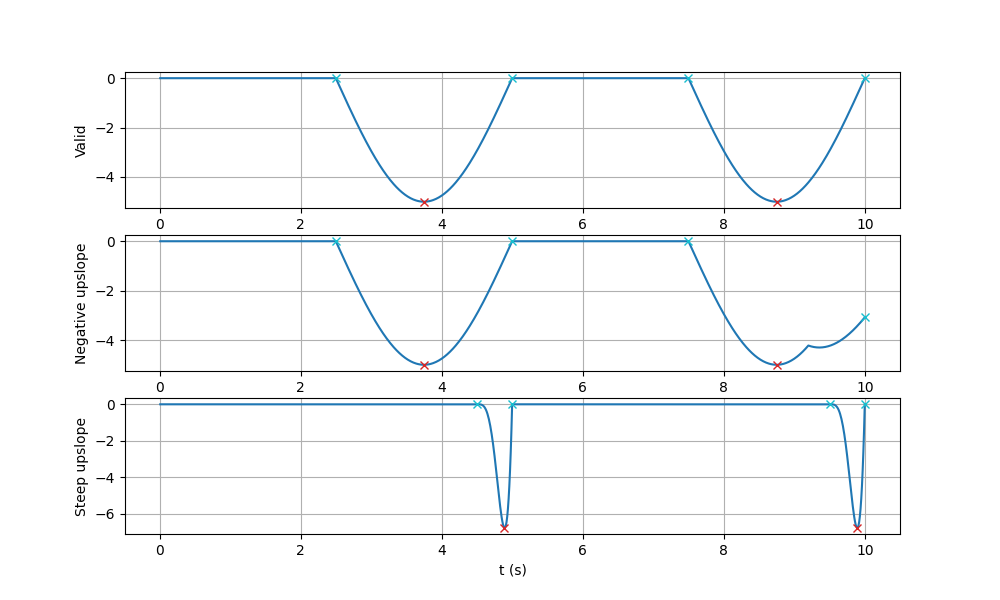

In [7]:
# Plot the raw data
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(10, 6))
axis[0].grid(True)
axis[0].plot(t_vent, y_t, color='tab:blue')
axis[0].plot(t_vent[peaks_source], y_t[peaks_source], 'x', color='tab:red')
axis[0].plot(t_vent[peak_starts], y_t[peak_starts], 'x', color='tab:cyan')
axis[0].plot(t_vent[peak_ends], y_t[peak_ends], 'x', color='tab:cyan')
axis[0].set_ylabel('Valid')

axis[1].grid(True)
axis[1].plot(t_vent, y_t_shifted, color='tab:blue')
axis[1].plot(t_vent[peaks_source], y_t_shifted[peaks_source], 'x', color='tab:red')
axis[1].plot(t_vent[peak_starts], y_t_shifted[peak_starts], 'x', color='tab:cyan')
axis[1].plot(t_vent[peak_ends], y_t_shifted[peak_ends], 'x', color='tab:cyan')
axis[1].set_ylabel('Negative upslope')

axis[2].grid(True)
axis[2].plot(t_vent, y_t_steeper, color='tab:blue')
axis[2].plot(t_vent[peaks_steeper], y_t_steeper[peaks_steeper], 'x', color='tab:red')
axis[2].plot(t_vent[peak_starts_steep], y_t_steeper[peak_starts_steep], 'x', color='tab:cyan')
axis[2].plot(t_vent[peak_ends_steep], y_t_steeper[peak_ends_steep], 'x', color='tab:cyan')
axis[2].set_ylabel('Steep upslope')

axis[2].set_xlabel('t (s)')